In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import PyCrystalField as cef
import scipy
from scipy.misc import derivative
import lmfit
import pandas as pd
from numba import njit

 *******************************************************
 *                PyCrystalField 2.3.9                 *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



In [3]:
temperature = 2 # in K

muB = 5.7883818012e-2  # meV/T
mu0 = np.pi*4e-7       # T*m/A
kB  = 8.617e-2         # [meV/K]
meVToCm =meVTocCmInv= 8.066 
ion = 'Er3+'

kBT = kB*temperature

Jperp = -0.2#e-3 #meV
Jz = -2.5#e-3 #meV
q= 6

In [95]:
# my fit vals
B20 = -0.03553308
B40 = -3.7973e-04
B43 = -0.01424079
B60 =  3.0728e-06
B63 = -2.7710e-07
B66 =  3.8956e-05 

g = cef.LandeGFactor(ion)
myBparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
MyErObj = cef.CFLevels.Bdict(ion,myBparams)


# neutron fit vals
B20 = -4.73e-2
B40 = -3.7037e-4
B43 = -1.44431e-2
B60 = 3.1605e-6
B63 = 6.5259e-6
B66 = 3.9314e-5

g = cef.LandeGFactor(ion)
AllenBparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
AllenErObj = cef.CFLevels.Bdict(ion,AllenBparams)

# okay, so now we rebuild with pcf built ins

In [96]:
#first do me

field = [[0,0,b] for b in np.linspace(-10,10,1000)]
magMe_C = np.array([MyErObj.magnetization(ion, temperature, f) for f in field]).T
field = np.array(field).T

# then do the neutron fit vals
field = [[0,0,b] for b in np.linspace(-10,10,1000)]
magAllen_C = np.array([AllenErObj.magnetization(ion, temperature, f) for f in field]).T
field = np.array(field).T


Text(0, 0.5, 'mag')

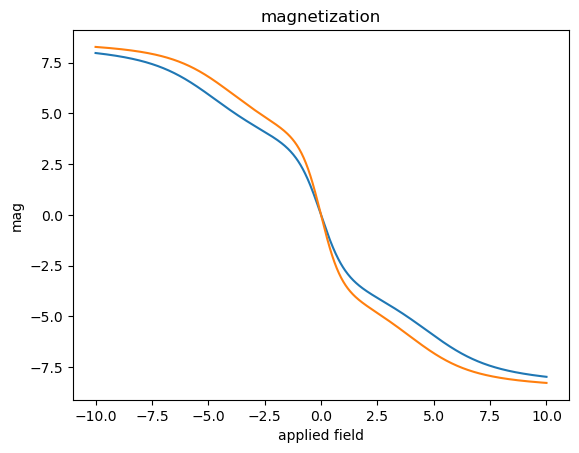

In [97]:
plt.plot(field[2], magMe_C[2])
plt.plot(field[2], magAllen_C[2])
plt.title('magnetization')
plt.xlabel('applied field')
plt.ylabel('mag')

# now we do MFT
this is following the code allen sent

Text(0, 0.5, 'magnetization')

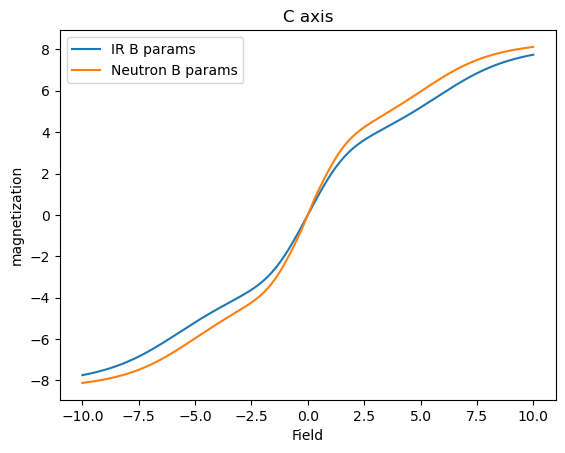

In [98]:
# f= field[2]
mme_C = magMe_C[2]
mAllen_C = magAllen_C[2]
f = np.linspace(-10,10,1000)
ffine = np.linspace(-10,10,len(mme_C))
muB = 5.7883818012e-2  
gJ = cef.LandeGFactor('Er3+')
# print(gJ)
# @njit

Jperp = -0.2e-3 #meV
Jz = -2.5e-3 #meV
q= 6

def MolecularFieldTheory(H, Hth, Mth, lamb):
    '''Use mean field theory to correct magnetization
    for an exchange strength lamb. H is the number of fields to calculate,
    Hth and Mth are the theoretical single-ion magnetization curves to correct.'''
    newM = np.interp(H, Hth, Mth)
    for i in range(10):
        newH = H - 6*lamb*newM/muB/(gJ)**2
        newM = np.interp(newH,Hth,Mth)
    return newM
 

# test = MolecularFieldTheory(np.array([1,4]), np.array([3,5]), np.array([3,5]), 0.1)

# define lamb for CES
lambAB = Jperp
lambC = Jz
 
maxi = 10

mft_mZ_me_C = MolecularFieldTheory(f, ffine, mme_C, lambC)
mft_mZ_Allen_C = MolecularFieldTheory(f, ffine, mAllen_C, lambC)

plt.plot(f, -1*mft_mZ_me_C, label = 'IR B params')
plt.plot(f, -1*mft_mZ_Allen_C, label = 'Neutron B params')
# plt.xlim(0,10)
# plt.ylim(0,9)
plt.legend()
plt.title('C axis')
plt.xlabel('Field')
plt.ylabel('magnetization')

# now lets llook at AB plane :(

Text(0.5, 1.0, 'AB magnetization')

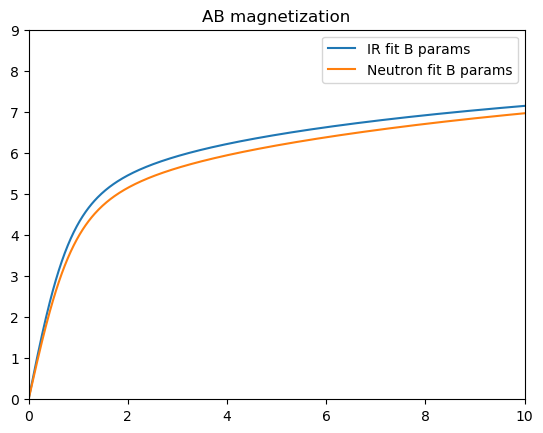

In [99]:

field = [[b,0,0] for b in np.linspace(-10,10,1000)]
magMe = np.array([MyErObj.magnetization(ion, temperature, f) for f in field]).T
field = np.array(field).T



field = [[b,0,0] for b in np.linspace(-10,10,1000)]
magAllen = np.array([AllenErObj.magnetization(ion, temperature, f) for f in field]).T
field = np.array(field).T

mme = magMe[0]
mAllen = magAllen[0]


Jperp = -0.2e-3/8 #meV
Jz = -2.5e-3/8 #meV
q= 6

def MolecularFieldTheory(H, Hth, Mth, lamb):
    '''Use mean field theory to correct magnetization
    for an exchange strength lamb. H is the number of fields to calculate,
    Hth and Mth are the theoretical single-ion magnetization curves to correct.'''
    newM = np.interp(H, Hth, Mth)
    for i in range(10):
        newH = H - 6*lamb*newM/muB/(gJ)**2
        newM = np.interp(newH,Hth,Mth)
    return newM
 

# test = MolecularFieldTheory(np.array([1,4]), np.array([3,5]), np.array([3,5]), 0.1)

# define lamb for CES
lambAB = Jperp
lambC = Jz
 
maxi = 10

mft_mZ_me = MolecularFieldTheory(f, ffine, mme, lambAB)
mft_mZ_Allen = MolecularFieldTheory(f, ffine, mAllen, lambAB)
plt.plot(f, -1*mft_mZ_me, label = 'IR fit B params')
plt.plot(ffine, -1*mft_mZ_Allen, label = 'Neutron fit B params')
plt.xlim(0,10)
plt.ylim(0,9)
plt.legend()
plt.title('AB magnetization')

# yee haw, lets load the data

In [100]:
Na = 6.02214076e23 
SCF = 1/(1.07828221e24/Na)
# import susceptibility
RawMTdata = np.genfromtxt('/Users/hopeless/Desktop/LeeLab/data/CsErSe2_MTall.dat', 
                       delimiter='\t', unpack=True, skip_header=1)
## Take some averages because it is TOO many data points
CESMTdata = []
for i in range(len(RawMTdata)):
    CESMTdata.append(np.mean(RawMTdata[i].reshape(-1,5), axis=1))

In [101]:
### Import magnetization

CESMHdata = np.genfromtxt('/Users/hopeless/Desktop/LeeLab/data/CsErSe2_MHall.dat', 
                       delimiter='\t', unpack=True, skip_header=1)

Text(0, 0.5, 'Magnetization (uB/Er)')

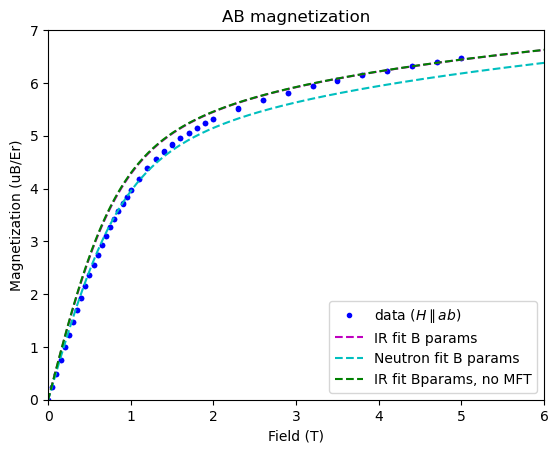

In [102]:
plt.plot(CESMHdata[0]/1e4,CESMHdata[1], 'b.', label='data ($H \\parallel ab$)')
plt.plot(f, -1*mft_mZ_me, '--m', label = 'IR fit B params')
plt.plot(ffine, -1*mft_mZ_Allen, '--c',label = 'Neutron fit B params')
plt.plot(f, -1*mme, '--g', label = 'IR fit Bparams, no MFT')
plt.xlim(0,6)
plt.ylim(0,7)
plt.legend()
plt.title('AB magnetization')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization (uB/Er)')
# plt.plot(CESMHdata[6]/1e4,CESMHdata[7],label='data ($H \\parallel c$)')

ValueError: x and y must have same first dimension, but have shapes (1000,) and (0,)

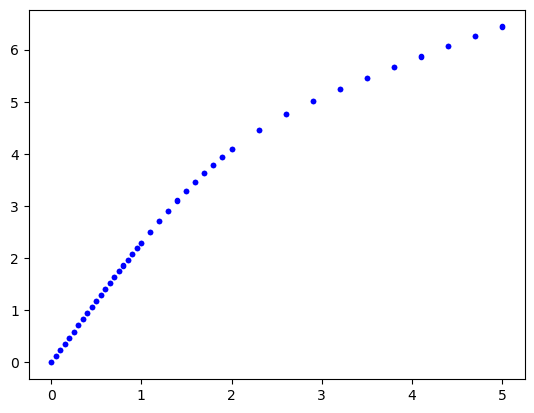

In [110]:
plt.plot(CESMHdata[6]/1e4,CESMHdata[7],'b.', label='data ($H \\parallel c$)')
plt.plot(f, -1*mft_mZ_me_C, '--m', label = 'IR fit B params')
plt.plot(f, -1*mft_mZ_Allen_C, '--c',label = 'Neutron fit B params')
plt.plot(f, -1*mme_C, '--g', label = 'IR fit Bparams, no MFT')
plt.xlim(0,6)
plt.ylim(0,10)
plt.legend()
plt.title('C magnetization')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization (uB/Er)')

In [ ]:


# field = [[0,0,b] for b in np.linspace(0,10,1000)]
# magMe = np.array([MyErObj.magnetization(ion, temperature, f) for f in field]).T
# field = np.array(field).T


# field = [[0,0,b] for b in np.linspace(0,10,1000)]
# magAllen = np.array([AllenErObj.magnetization(ion, temperature, f) for f in field]).T
# field = np.array(field).T

f = np.linspace(0,10,100)
# mme = magMe[0]
# mAllen = magAllen[0]

# tempArr = [.01, .1, .2, .5, .8,1,1.5,1.6,1.7,1.8,1.9,2]



plt.figure()
for temperature in tempArr: 
    field = [[0,0,b] for b in np.linspace(0,10,100)]
    magMe = np.array([MyErObj.magnetization(ion, temperature, f) for f in field]).T
    field = np.array(field).T
    mme_C = magMe[2]
    mft_mZ_me_C = MolecularFieldTheory(f, f, mme_C, lambC)
    mft_mZ_me_C = [m*-1 for m in mft_mZ_me_C]
    # mft_mZ_Allen_C = MolecularFieldTheory(f, ffine, mAllen_C, lambC)
    plt.plot(f, mft_mZ_me_C, label = str(temperature)+'K')
plt.legend()
plt.title('C axis magnetization')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization')

# real quick lets do a couple temps 

In [ ]:
temps = [.01, .1, .2, .5, .8,1,1.5,1.6,1.7,1.8,1.9,2]
for t in temps: 
    f =np.linspace(0,6,1000)
    field = [[0,0,b] for b in f]
    magMe = np.array([MyErObj.magnetization(ion, t, f)*-1 for f in field]).T
    mft_mZ_me = MolecularFieldTheory(f, f, magMe[2], lambC)
    field = np.array(field).T
    plt.plot(field[2], np.gradient(mft_mZ_me), label = str(t)+'K')

plt.legend()
plt.xlabel(' applied field')
plt.ylabel('dm/dH')
# plt.xlim(0,7)
plt.ylim(-.1,.5)
plt.title('C axis dM/dH')

# now susceptibility

In [ ]:
def susceptibility(ionObj, fieldVal, temps):
    chi = []
    for temp in temps: 
        # f = newfreeEnergy(field, temp)
        # m = np.gradient(f, dx)
        f, dx = np.linspace(1-fieldVal, 1+fieldVal, 100,retstep = True) 
        field = [[0,0,b] for b in f]
        mag= np.array([ErObj.magnetization(ion, temp, f) for f in field]).T
        m = MolecularFieldTheory(f, f, mag[2], Jz)
        # m, dx, field = 1-fieldVal,1+fieldVal, temperature = temp, numpoints =100)
        m = np.array(m).T
        x = np.gradient(m, dx) 
        # now we've gotta access the very low field value
        valIdx = findIdx(field, [0,0,fieldVal])
        chi.append(x[valIdx])
        # chi.append(x)
    return chi
def findIdx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [ ]:
temps = np.linspace(0.1,300,300)
fieldVal = .1
df = 0.001
mysus = susceptibility(MyErObj, fieldVal, temps) #myErObj.susceptibility(ion, temps, field, df)
# sus = ErObj.susceptibility(ion, temps, field, df)
neutronSus = susceptibility(AllenErObj, fieldVal, temps)

In [ ]:
field = [0,0,.1]
sus = ErObj.susceptibility(ion, temps, field, df)
sus = np.array(sus).T

In [ ]:
myinv = [-1/x for x in mysus]
neutroninv = [-1/x for x in neutronSus]
# sus =  [ErObj.susceptibility(ion, t, field, df) for t in temps]
susinv = [-1/x for x in sus[2]]
plt.plot(temps, myinv, '--m', label = 'IR')
plt.plot(temps, neutroninv, '-.c', label = 'neutrons' )
plt.plot(temps, susinv, label = 'pcf susceptibility')
plt.title('calculated MFT susceptibility at 0.1T ')
plt.xlabel('temperature (K)')
plt.ylabel('1/chi')
plt.legend()
# plt.xlim(0,10)

# now we do susceptibility as a fn of field

In [ ]:
def susceptibilityConstTemp(ionObj, fields, temp):
    field = [[0,0,b] for b in fields]
    f = fields
    magMe = np.array([ionObj.magnetization(ion, temp, f)*-1 for f in field]).T
    mft_mZ_me = MolecularFieldTheory(f, f, magMe[2], lambC)
    field = np.array(field).T
    chi = np.gradient(mft_mZ_me)*-1
    return chi

In [ ]:

temps = [.01, .1, .2, .5, .8,1,1.5,1.6,1.7,1.8,1.9,2]
fields = np.linspace(-1,10,1000)
mychi = []
for t in temps: 
    x = susceptibilityConstTemp(MyErObj, fields, t)
    x = [-c for c in x]
    mychi.append(x)


In [ ]:


for i in range(len(mychi)):
    plt.plot(fields, mychi[i], label = str(temps[i])+'K')
    # plt.legend()
    plt.xlabel('field')
    plt.ylabel('chi')

plt.title('IR b params')
plt.xlim(0,10)
# plt.yscale('log')
plt.ylim(-.2,.2)


In [ ]:
temps = np.linspace(0.01,1,15)
fields = np.linspace(0,10,1000)
chi = []
for t in temps: 
    x = susceptibilityConstTemp(ErObj, fields, t)
    x = [-chi for chi in x]
    chi.append(x)

In [ ]:
for i in range(len(chi)):
    plt.plot(fields, chi[i], label = str(temps[i])+'K')
    plt.legend()
    plt.xlabel('field')
    plt.ylabel('chi')

plt.title('Neutron b params')
# plt.yscale('log')

In [ ]:
plt.plot(fields,chi[2], label= 'neutron B')
plt.plot(fields, mychi[2], label = 'IR B' )
plt.legend()
plt.yscale('log')